<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/XGBoost(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from xgboost.callback import EarlyStopping

In [ ]:
# XGBoost Production Classification Model
# Step-by-step implementation with comprehensive evaluation
# SEPARATED VISUALIZATIONS VERSION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


In [ ]:

# Step 1: Load the datasets
print("Step 1: Loading datasets...")
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"Training data shape: {train_df.shape}")
    print(f"Validation data shape: {validation_df.shape}")
    print(f"Test data shape: {test_df.shape}")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")


Step 1: Loading datasets...
Training data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)


In [ ]:

# Step 2: Data preprocessing and label creation
print("\nStep 2: Creating quantile-based labels...")

def create_quantile_labels(df, target_column='Production (M.Ton)'):
    """Create low, medium, high labels based on quantiles"""
    # Calculate quantiles
    q33 = df[target_column].quantile(0.33)
    q67 = df[target_column].quantile(0.67)

    # Create labels
    labels = []
    for value in df[target_column]:
        if value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')

    return labels, q33, q67

# Create labels for training data (use training quantiles for all datasets)
train_labels, q33, q67 = create_quantile_labels(train_df)
train_df['production_category'] = train_labels

print(f"Quantile boundaries - Q33: {q33:.2f}, Q67: {q67:.2f}")
print(f"Training label distribution:")
print(train_df['production_category'].value_counts())

# Apply same quantile boundaries to validation and test sets
def apply_quantile_labels(df, q33, q67, target_column='Production (M.Ton)'):
    """Apply predefined quantile boundaries to create labels"""
    labels = []
    for value in df[target_column]:
        if value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

validation_df['production_category'] = apply_quantile_labels(validation_df, q33, q67)
test_df['production_category'] = apply_quantile_labels(test_df, q33, q67)

print(f"\nValidation label distribution:")
print(validation_df['production_category'].value_counts())
print(f"\nTest label distribution:")
print(test_df['production_category'].value_counts())



Step 2: Creating quantile-based labels...
Quantile boundaries - Q33: 1071.56, Q67: 4035.91
Training label distribution:
production_category
medium    1340
low       1301
high      1301
Name: count, dtype: int64

Validation label distribution:
production_category
medium    297
low       278
high      270
Name: count, dtype: int64

Test label distribution:
production_category
high      291
medium    280
low       274
Name: count, dtype: int64


In [ ]:

# Step 3: Prepare features and target variables
print("\nStep 3: Preparing features and target variables...")

# Define feature columns (exclude target and its category)
feature_columns = [col for col in train_df.columns if col not in ['Production (M.Ton)', 'production_category']]

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df['production_category']

X_val = validation_df[feature_columns]
y_val = validation_df['production_category']

X_test = test_df[feature_columns]
y_test = test_df['production_category']

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Feature columns: {len(feature_columns)}")
print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")



Step 3: Preparing features and target variables...
Feature columns: 83
Label encoding: {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}


In [ ]:

# Step 4: Initialize and configure XGBoost model
print("\nStep 4: Initializing XGBoost model...")

# Create XGBoost classifier
xgb_model = XGBClassifier(
    max_depth=8,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    early_stopping_rounds=10,
    enable_categorical=False
)



Step 4: Initializing XGBoost model...


In [ ]:
# Step 5: Training with validation monitoring
print("\nStep 5: Training the model...")

# Fit the model with evaluation sets
xgb_model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_val, y_val_encoded)],
    verbose=False
)

# For plotting training curves, we'll train a separate model to capture history
print("Training model with history tracking...")

# Create a simple training loop to track metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Split training into smaller batches to simulate epochs
n_estimators_per_epoch = 10
total_epochs = 10

for epoch in range(total_epochs):
    # Create model for this epoch
    current_estimators = (epoch + 1) * n_estimators_per_epoch
    temp_model = XGBClassifier(
        max_depth=8,
        learning_rate=0.1,
        n_estimators=current_estimators,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    )

    # Fit model
    temp_model.fit(X_train, y_train_encoded, verbose=False)

    # Get predictions and calculate accuracy
    train_pred = temp_model.predict(X_train)
    val_pred = temp_model.predict(X_val)

    # Get prediction probabilities for loss calculation
    train_pred_proba = temp_model.predict_proba(X_train)
    val_pred_proba = temp_model.predict_proba(X_val)

    train_acc = accuracy_score(y_train_encoded, train_pred)
    val_acc = accuracy_score(y_val_encoded, val_pred)

    # Calculate log loss (cross-entropy loss)
    from sklearn.metrics import log_loss
    train_loss = log_loss(y_train_encoded, train_pred_proba)
    val_loss = log_loss(y_val_encoded, val_pred_proba)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{total_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print(f"Training completed.")



Step 5: Training the model...
Training model with history tracking...
Epoch 1/10 - Train Acc: 0.9419, Val Acc: 0.8876, Train Loss: 0.5338, Val Loss: 0.5790
Epoch 2/10 - Train Acc: 0.9495, Val Acc: 0.8876, Train Loss: 0.3161, Val Loss: 0.3881
Epoch 3/10 - Train Acc: 0.9561, Val Acc: 0.8888, Train Loss: 0.2272, Val Loss: 0.3161
Epoch 4/10 - Train Acc: 0.9627, Val Acc: 0.8947, Train Loss: 0.1778, Val Loss: 0.2813
Epoch 5/10 - Train Acc: 0.9721, Val Acc: 0.8982, Train Loss: 0.1467, Val Loss: 0.2631
Epoch 6/10 - Train Acc: 0.9792, Val Acc: 0.9018, Train Loss: 0.1261, Val Loss: 0.2525
Epoch 7/10 - Train Acc: 0.9860, Val Acc: 0.9065, Train Loss: 0.1081, Val Loss: 0.2447
Epoch 8/10 - Train Acc: 0.9893, Val Acc: 0.9041, Train Loss: 0.0946, Val Loss: 0.2412
Epoch 9/10 - Train Acc: 0.9937, Val Acc: 0.9077, Train Loss: 0.0830, Val Loss: 0.2379
Epoch 10/10 - Train Acc: 0.9952, Val Acc: 0.9041, Train Loss: 0.0736, Val Loss: 0.2361
Training completed.


In [ ]:
# Step 6: Make predictions
print("\nStep 6: Making predictions...")

# Training predictions
y_train_pred = xgb_model.predict(X_train)
y_train_pred_proba = xgb_model.predict_proba(X_train)

# Validation predictions
y_val_pred = xgb_model.predict(X_val)
y_val_pred_proba = xgb_model.predict_proba(X_val)

# Test predictions
y_test_pred = xgb_model.predict(X_test)
y_test_pred_proba = xgb_model.predict_proba(X_test)


Step 6: Making predictions...


In [ ]:


# Step 7: Calculate evaluation metrics
print("\nStep 7: Calculating evaluation metrics...")

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate comprehensive classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"\n{dataset_name} Dataset Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train_encoded, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val_encoded, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test_encoded, y_test_pred, "Test")


Step 7: Calculating evaluation metrics...

Training Dataset Metrics:
Accuracy: 0.9952
Precision (Weighted): 0.9952
Recall (Weighted): 0.9952
F1-Score (Weighted): 0.9952
F1-Score (Macro): 0.9952

Validation Dataset Metrics:
Accuracy: 0.9041
Precision (Weighted): 0.9045
Recall (Weighted): 0.9041
F1-Score (Weighted): 0.9042
F1-Score (Macro): 0.9052

Test Dataset Metrics:
Accuracy: 0.9207
Precision (Weighted): 0.9223
Recall (Weighted): 0.9207
F1-Score (Weighted): 0.9212
F1-Score (Macro): 0.9211



Step 8: Creating individual visualizations...
Creating Figure 1: Training vs Validation Accuracy...


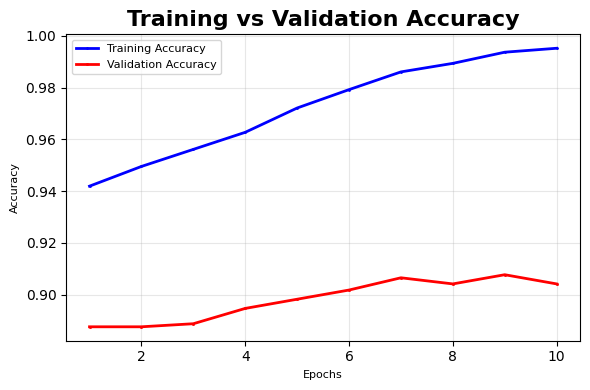

Creating Figure 2: Training vs Validation Loss...


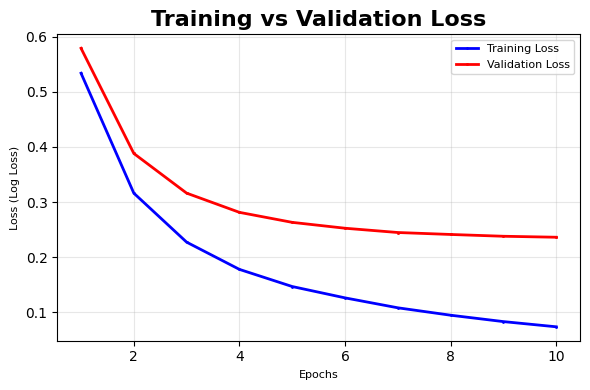

In [ ]:
# ============================================================================
# SEPARATED VISUALIZATIONS - EACH PLOT AS INDIVIDUAL FIGURE
# ============================================================================
print("\nStep 8: Creating individual visualizations...")

# FIGURE 1: Training vs Validation Accuracy (Updated to match loss plot style)
print("Creating Figure 1: Training vs Validation Accuracy...")
plt.figure(figsize=(6, 4))  # Adjust size as needed
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=1)
plt.plot(epochs, val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2, markersize=1)
plt.title('Training vs Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 2: Training vs Validation Loss
print("Creating Figure 2: Training vs Validation Loss...")
plt.figure(figsize=(6, 4))  # Adjust size as needed
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=1)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=1)
plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss (Log Loss)', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Creating Figure 3: Validation Confusion Matrix...


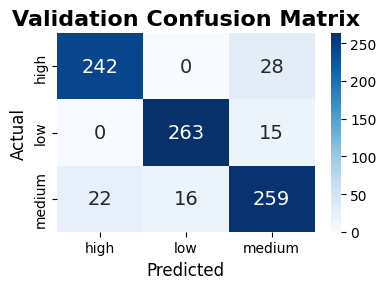

Creating Figure 4: Test Confusion Matrix...


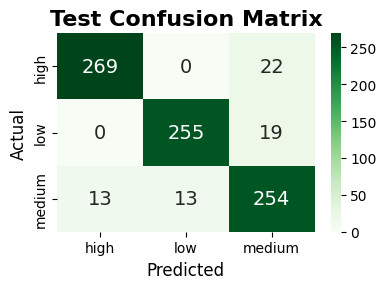

In [ ]:

# FIGURE 3: Validation Confusion Matrix
print("Creating Figure 3: Validation Confusion Matrix...")
plt.figure(figsize=(4, 3))  # Adjust size as needed
cm_val = confusion_matrix(y_val_encoded, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 14})
plt.title('Validation Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()



# FIGURE 4: Test Confusion Matrix
print("Creating Figure 4: Test Confusion Matrix...")
plt.figure(figsize=(4, 3))  # Adjust size as needed
cm_test = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={'size': 14})
plt.title('Test Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

Creating Figure 5: Model Accuracy Comparison...


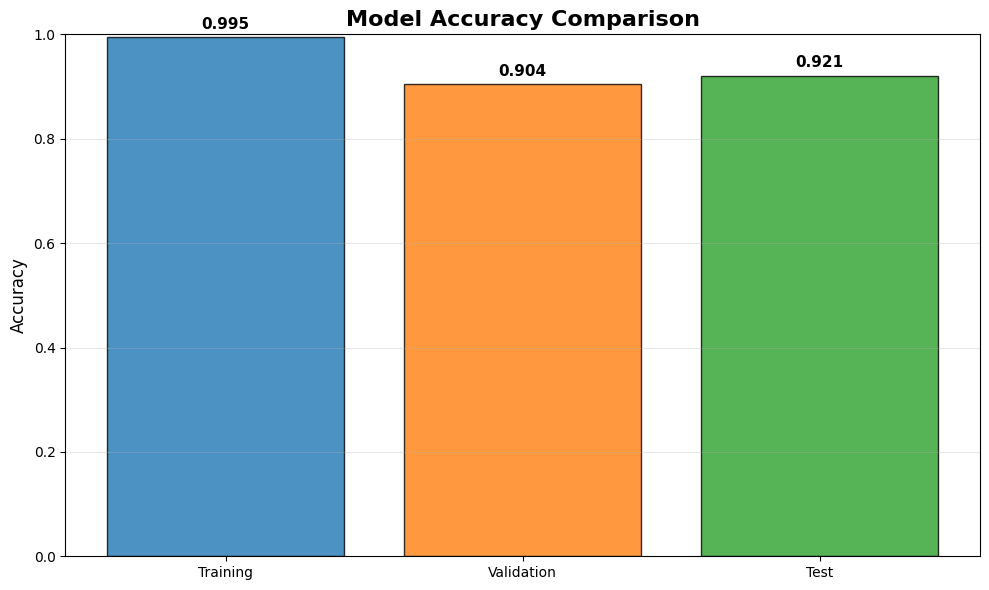

Creating Figure 6: F1 Score Comparison...


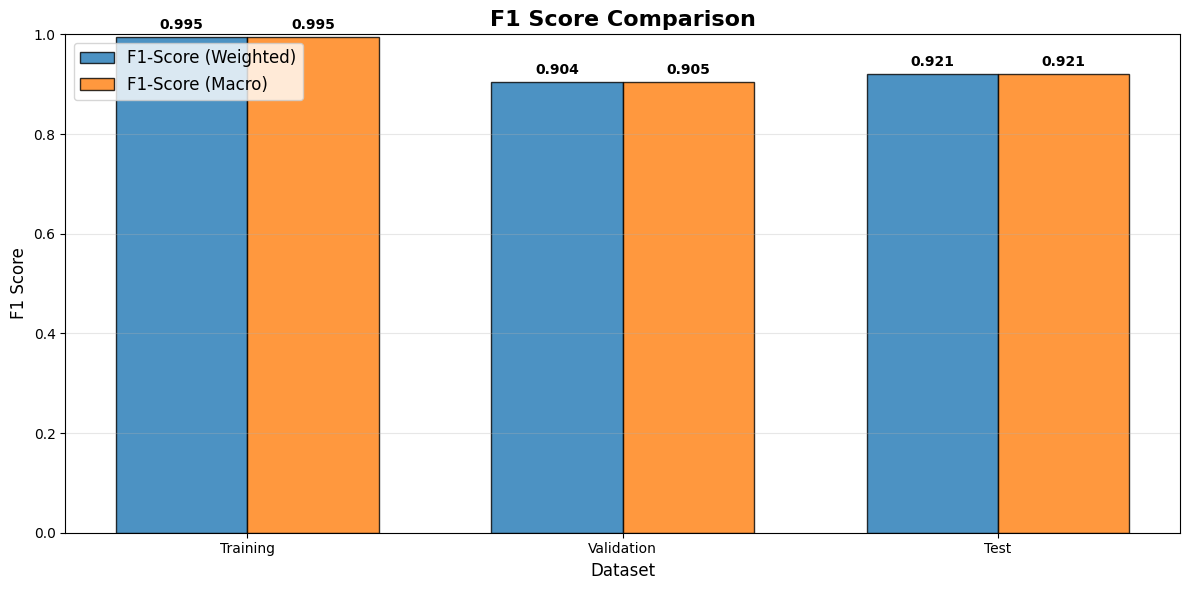

In [ ]:


# FIGURE 5: Model Accuracy Comparison
print("Creating Figure 5: Model Accuracy Comparison...")
plt.figure(figsize=(10, 6))  # Adjust size as needed
datasets = ['Training', 'Validation', 'Test']
accuracies = [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = plt.bar(datasets, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

# FIGURE 6: F1 Score Comparison
print("Creating Figure 6: F1 Score Comparison...")
plt.figure(figsize=(12, 6))  # Adjust size as needed
x = np.arange(len(datasets))
width = 0.35

f1_weighted = [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']]
f1_macro = [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]

bars1 = plt.bar(x - width/2, f1_weighted, width, label='F1-Score (Weighted)',
                color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = plt.bar(x + width/2, f1_macro, width, label='F1-Score (Macro)',
                color='#ff7f0e', alpha=0.8, edgecolor='black')

plt.title('F1 Score Comparison', fontsize=16, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.xticks(x, datasets)
plt.legend(fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars, values in [(bars1, f1_weighted), (bars2, f1_macro)]:
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


Creating Figure 7: Feature Importance...


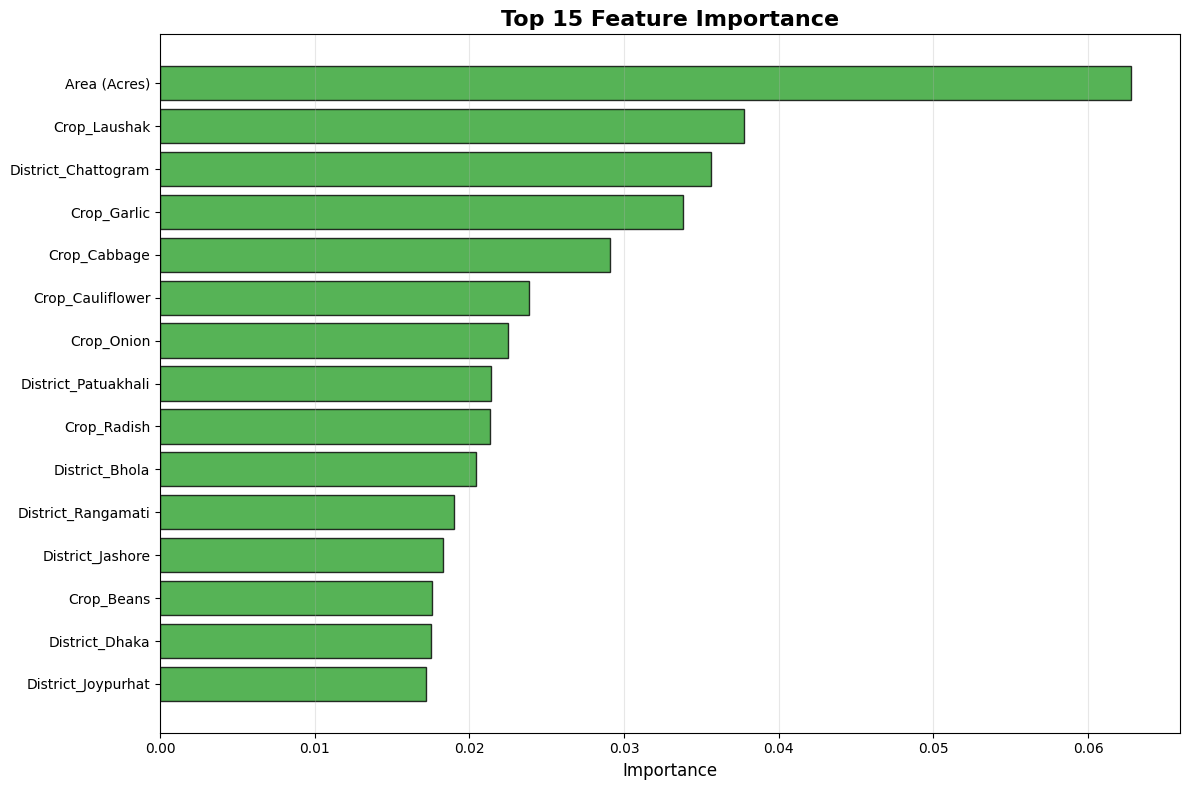

Creating Figure 8: Metrics Summary Heatmap...


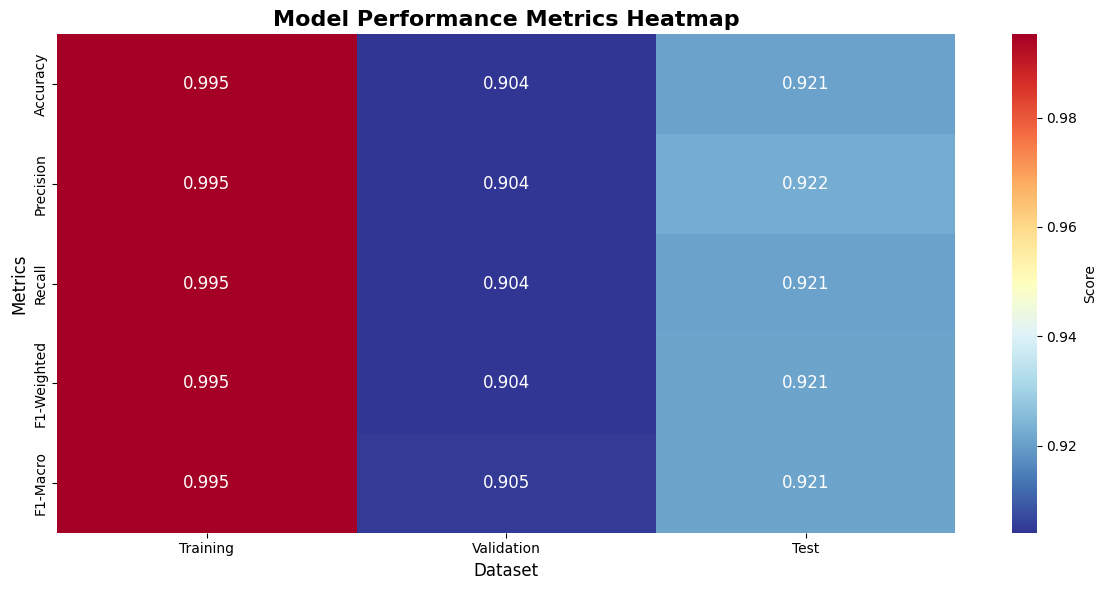

In [ ]:

# FIGURE 7: Feature Importance (Top 15)
print("Creating Figure 7: Feature Importance...")
plt.figure(figsize=(12, 8))  # Adjust size as needed
feature_importance = xgb_model.feature_importances_
feature_names = feature_columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)  # Changed to True for better visualization

top_features = importance_df.tail(15)  # Use tail to get top 15
plt.barh(range(len(top_features)), top_features['importance'],
         color='#2ca02c', alpha=0.8, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
plt.title('Top 15 Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# FIGURE 8: Metrics Summary Heatmap (Bonus visualization)
print("Creating Figure 8: Metrics Summary Heatmap...")
plt.figure(figsize=(12, 6))  # Adjust size as needed
metrics_data = {
    'Training': [train_metrics['accuracy'], train_metrics['precision'],
                 train_metrics['recall'], train_metrics['f1_weighted'], train_metrics['f1_macro']],
    'Validation': [val_metrics['accuracy'], val_metrics['precision'],
                   val_metrics['recall'], val_metrics['f1_weighted'], val_metrics['f1_macro']],
    'Test': [test_metrics['accuracy'], test_metrics['precision'],
             test_metrics['recall'], test_metrics['f1_weighted'], test_metrics['f1_macro']]
}

metrics_df = pd.DataFrame(metrics_data,
                         index=['Accuracy', 'Precision', 'Recall', 'F1-Weighted', 'F1-Macro'])

sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='RdYlBu_r',
            cbar_kws={'label': 'Score'}, annot_kws={'size': 12})
plt.title('Model Performance Metrics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Step 9: Detailed Classification Reports
print("\nStep 9: Detailed Classification Reports...")

print("\n" + "="*50)
print("VALIDATION SET CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_val_encoded, y_val_pred,
                          target_names=label_encoder.classes_))

print("\n" + "="*50)
print("TEST SET CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test_encoded, y_test_pred,
                          target_names=label_encoder.classes_))

# Step 10: Summary Table
print("\nStep 10: Summary of Results...")
print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*80)

summary_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
    'Precision (Weighted)': [train_metrics['precision'], val_metrics['precision'], test_metrics['precision']],
    'Recall (Weighted)': [train_metrics['recall'], val_metrics['recall'], test_metrics['recall']],
    'F1-Score (Weighted)': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']],
    'F1-Score (Macro)': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]
})

print(summary_df.to_string(index=False, float_format='%.4f'))

# Step 11: Model Information
print("\n" + "="*50)
print("MODEL CONFIGURATION")
print("="*50)
print(f"Model Type: XGBoost Classifier")
print(f"Number of Classes: 3 (low, medium, high)")
print(f"Number of Features: {len(feature_columns)}")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Test Samples: {len(X_test)}")
print(f"Total Epochs: {total_epochs}")
print(f"Quantile Boundaries: Q33={q33:.2f}, Q67={q67:.2f}")

print("\nModel training and evaluation completed successfully!")
print("All visualizations have been created as separate figures for individual customization.")


Step 9: Detailed Classification Reports...

VALIDATION SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        high       0.92      0.90      0.91       270
         low       0.94      0.95      0.94       278
      medium       0.86      0.87      0.86       297

    accuracy                           0.90       845
   macro avg       0.91      0.90      0.91       845
weighted avg       0.90      0.90      0.90       845


TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        high       0.95      0.92      0.94       291
         low       0.95      0.93      0.94       274
      medium       0.86      0.91      0.88       280

    accuracy                           0.92       845
   macro avg       0.92      0.92      0.92       845
weighted avg       0.92      0.92      0.92       845


Step 10: Summary of Results...

COMPREHENSIVE MODEL PERFORMANCE SUMMARY
   Dataset  Accuracy  Precision (Weighted)  Recall 